# Retweet or not?

## Fetch and Clean data from Twitter

This part of the notebook will fetch WDR_Verkehr's tweets from Twitter and clean the texts up. Afterwards they will be stored to a CSV file.

The first cell holds all the access configuration for Twitter.

In [1]:
import os

import tweepy
from tweepy import OAuthHandler
import locale


locale.setlocale(locale.LC_ALL,'de_DE.UTF-8')

consumer_key = os.environ.get('TWITTER_CONSUMER_KEY')
consumer_secret = os.environ.get('TWITTER_CONSUMER_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

Let's get it on! now we either fetch all the tweets or we simply load them from disk. It's up to you.

In [2]:
all_tweets = []

In [3]:
import json


def process_or_store(tweet):
    print('processing tweet {}... {} in total\r'.format(tweet['id'], len(all_tweets)), end='', flush=True)
    
    all_tweets.append(tweet)

try:
    for tweet in tweepy.Cursor(api.user_timeline, id='WDR_Verkehr',tweet_mode='extended').items():
        process_or_store(tweet._json)
    for tweet in tweepy.Cursor(api.user_timeline, id='StrassenNRW',tweet_mode='extended').items():
        process_or_store(tweet._json)
        
finally:
    with open('strassen-tweets.json', 'w') as outfile:
        json.dump(all_tweets, outfile)
    
    print('\nDONE! I save {} tweets to disk'.format(len(all_tweets)))

processing tweet 122243671411269632... 3895 in total
DONE! I save 3896 tweets to disk


In [4]:
import json


with open('strassen-tweets.json', 'r') as tweet_store:
        all_tweets = json.load(tweet_store)

print('I read {} tweets from disk'.format(len(all_tweets)))

I read 3896 tweets from disk


# Tokenize and Cleanup

The following cells will tokenize and clean up the texts.

In [5]:
from nltk.corpus import stopwords
import string
import nltk
import re


emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, strip_handles=True)
stop = stopwords.words('german') + list(string.punctuation)
    
def process_tweet(tweet):
    tokens = [token for token in tokenizer.tokenize(emoji_pattern.sub('', tweet['full_text'])) if token not in stop and not token.startswith(('@', 'http'))]

    return tokens

... and for each tweet mentioning A565 we will set a one hot encoded retweet feature.

In [6]:
from collections import Counter
from nltk import bigrams 


for idx, tweet in enumerate(all_tweets, start=0):
    terms = process_tweet(tweet)
    
    all_tweets[idx]['retweet'] = 0

    if ('#a565' in terms) or ('a565' in terms):
        all_tweets[idx]['retweet'] = 1
    if ('bonn' in terms) and ('vilich' in terms):
        all_tweets[idx]['retweet'] = 1        
        
    all_tweets[idx]['tokens'] = terms

The following cell will just write our cleaned data to a file on disk.

In [7]:
import csv


with open('wdr-verkehr-tweets_clean.csv', 'w') as f:
    writer = csv.writer(f)
    
    writer.writerow(['text','user','retweet'])
    
    for tweet in all_tweets:
        if tweet['full_text'] is None:
            print('NAN')
        else:
            writer.writerow([tweet['full_text'],tweet['user']['screen_name'],tweet['retweet']])


Let's build a text corpus and a target labeling for it. This is more or less just a copy of `all_tweets`.

In [8]:
corpus = []
retweet = []

for tweet in all_tweets:
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet['full_text'], flags=re.MULTILINE)

    corpus.append(text)
    retweet.append(tweet['retweet'])

Now that we got X (corpus) and y (retweet), we will split it up in a training and test set.

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd


X = pd.DataFrame(corpus, columns=["text"])
y = pd.DataFrame(retweet)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3409, 1) (3409, 1)
(487, 1) (487, 1)


let's make sure we have retweets in the test set

In [10]:
import numpy as np


np.count_nonzero(y_test)

8

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop)
tfidf_transformer = TfidfTransformer()

X_train_counts = vectorizer.fit_transform(corpus)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [12]:
from sklearn.naive_bayes import MultinomialNB


clf = MultinomialNB().fit(X_train_tfidf, retweet)

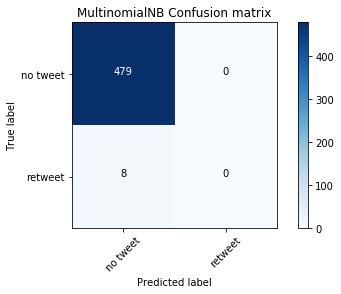

In [13]:
import itertools

%matplotlib inline  
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


X_cm_counts = vectorizer.transform(X_test["text"])
X_cm_tfidf = tfidf_transformer.transform(X_cm_counts)

y_pred = clf.predict(X_cm_tfidf)


clf_cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(clf_cnf_matrix, classes=['no tweet', 'retweet'],
                      title='MultinomialNB Confusion matrix')

plt.show()


In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline


text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                          max_iter=5, tol=None)),
])

text_clf.fit(corpus, retweet)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

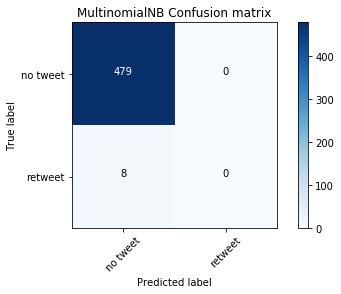

In [15]:
y_pred = text_clf.predict(X_test["text"])

text_clf_cnf_matrix = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(clf_cnf_matrix, classes=['no tweet', 'retweet'],
                      title='MultinomialNB Confusion matrix')

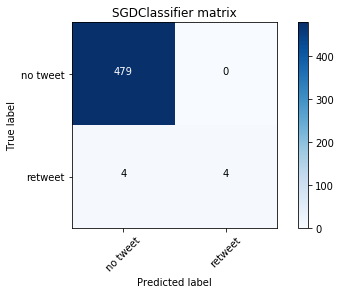

In [16]:
plot_confusion_matrix(text_clf_cnf_matrix, classes=['no tweet', 'retweet'],
                      title='SGDClassifier matrix')

Looking good?! let's have a short look at the accuracy of the SGDClassifier pipeline:

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['no tweet', 'retweet']))

0.9917864476386037
             precision    recall  f1-score   support

   no tweet       0.99      1.00      1.00       479
    retweet       1.00      0.50      0.67         8

avg / total       0.99      0.99      0.99       487



Finally we will save the model to disk using `joblib`. To verify that all worked ok we load the model from disk and preduct some!

In [18]:
from sklearn.externals import joblib


# seeAlso http://stackabuse.com/scikit-learn-save-and-restore-models/

joblib_file = 'model.pkl'  
joblib.dump(text_clf, joblib_file)

['model.pkl']